In [5]:
import matplotlib.pyplot as plt
import json
from Bio import SeqIO
import math
import subprocess
import random


In [3]:
clusters_lengths = [
    len(r.seq)
    for r in SeqIO.parse("../large_data/longest_seqs_from_clusters.fasta", "fasta")
]
homologues_lengths = [
    len(r.seq) for r in SeqIO.parse("../large_data/homologues.fasta", "fasta")
]
orfs_lengths = [len(r.seq) for r in SeqIO.parse("../large_data/orfs.fasta", "fasta")]


In [51]:
def get_disorder_results(file_path):
    sequence_lengths = [len(r.seq) for r in SeqIO.parse(file_path, "fasta")]
    result = subprocess.run(
        [
            "python3",
            "../large_data/iupred2a/iupred2a.py",
            file_path,
            "short",
        ],
        capture_output=True,
        text=True,
    )

    results = result.stdout.split("\n")
    results_floats = [float(x) for x in results if x != ""]
    results_per_sequence = list()
    cursor = 0
    for length in sequence_lengths:
        results_per_sequence.append(results_floats[cursor : cursor + length])
        cursor += length
    disorder_percentage_per_seq = list()
    for seq in results_per_sequence:
        disorder_percentage_per_seq.append(sum(i > 0.5 for i in seq) / len(seq))
    return disorder_percentage_per_seq


In [55]:
number_of_random_species = 5000

In [57]:
with open("../data/species_list.json") as json_file:
    available_species_list = json.load(json_file)

orf_results = list()
trg_results = list()
hom_results = list()
for i in range(number_of_random_species):
    species = random.sample(available_species_list, 1)[0]
    available_species_list.remove(species)
    file_path = f"../large_data/protein_faa_reps/bacteria/{species}"
    orf_results += get_disorder_results(file_path + "_orfs.fasta")
    trg_results += get_disorder_results(file_path + "_clusters.fasta")
    hom_results += get_disorder_results(file_path + "_homologues.fasta")



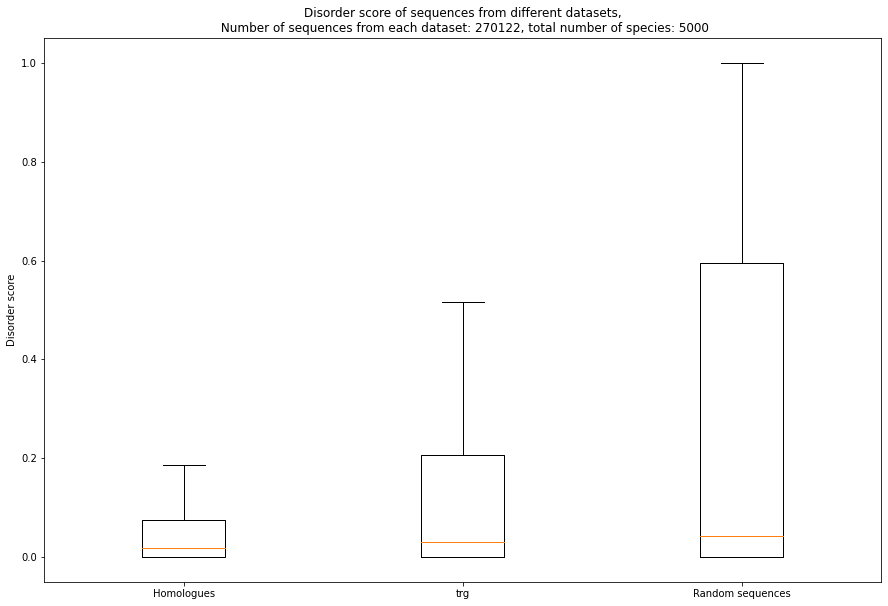

In [62]:
assert len(orf_results) == len(trg_results) == len(hom_results)
plt.gcf().set_size_inches(15, 10)
plt.title(f"Disorder score of sequences from different datasets,\n Number of sequences from each dataset: {len(orf_results)}, total number of species: {number_of_random_species}")
plt.ylabel("Disorder score")
plt.boxplot(x=[hom_results, trg_results, orf_results],showfliers=False)
plt.xticks([1, 2, 3], ["Homologues", "trg", "Random sequences"])
plt.show()
